# Autoencoders for image denoising

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the autoencoder](#build)
3. [Train the autoencoder](#train)
3. [Predict using the autoencoder](#predict)
3. [Denoising using the autoencoder](#denoise)

In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory

from utils.image import preprocess, noise, display, sample_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [260]:
IMAGE_SIZE = 64
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
NOISE_FACTOR = 0.4
Z_DIM = 128
EPOCHS = 100

## 1. Prepare the data <a name="prepare"></a>

In [241]:
train_data = image_dataset_from_directory(
    "../../data/lego/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
)

test_data = image_dataset_from_directory(
    "../../data/lego/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.
Using 32000 files for training.
Found 40000 files belonging to 1 classes.
Using 8000 files for validation.


In [242]:
train = train_data.map(lambda x: preprocess(x))
test = test_data.map(lambda x: preprocess(x))

In [243]:
train_sample = sample_batch(train)
test_sample = sample_batch(test)

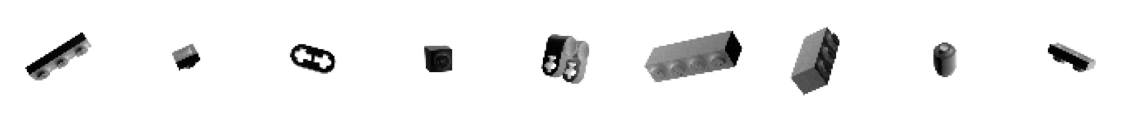

In [244]:
display(train_sample)

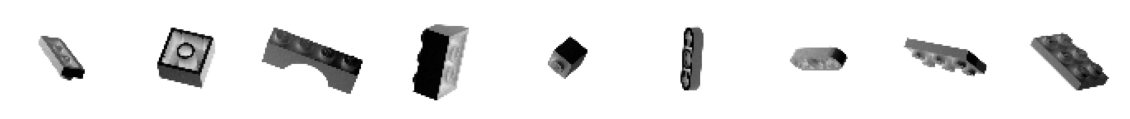

In [245]:
display(test_sample)

In [246]:
noisy_train = train.map(lambda x: noise(x, NOISE_FACTOR))
noisy_test = test.map(lambda x: noise(x, NOISE_FACTOR))

noisy_train_sample = np.array([noise(x, NOISE_FACTOR) for x in train_sample])
noisy_test_sample = np.array([noise(x, NOISE_FACTOR) for x in test_sample])

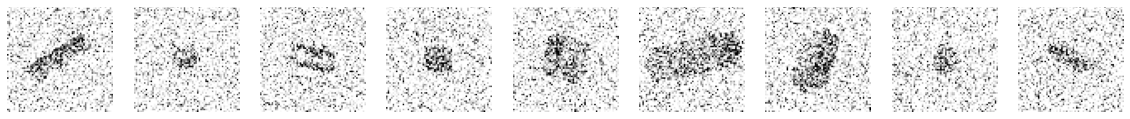

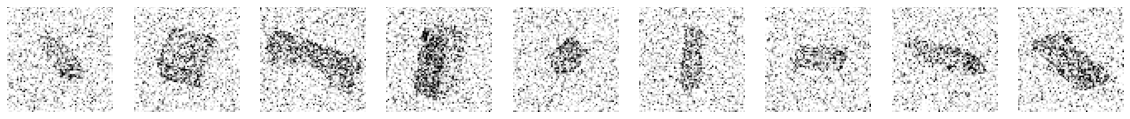

In [247]:
display(noisy_train_sample)
display(noisy_test_sample)

## 2. Build the autoencoder <a name="build"></a>

In [262]:
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(256, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(Z_DIM, activation="relu", name="encoder_output")(x)

# # # Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
encoder = Model(encoder_input, encoder_output)
decoder = Model(decoder_input, decoder_output)
autoencoder = Model(encoder_input, decoder(encoder_output))  # decoder(encoder_output)

autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_313 (Conv2D)         (None, 32, 32, 32)        320       
                                                                 
 conv2d_314 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_315 (Conv2D)         (None, 8, 8, 128)         73856     
                                                                 
 conv2d_316 (Conv2D)         (None, 4, 4, 256)         295168    
                                                                 
 flatten_32 (Flatten)        (None, 4096)              0         
                                                                 
 encoder_output (Dense)      (None, 128)               52

## 3. Train the autoencoder <a name="train"></a>

In [263]:
train_in = train.map(lambda x: (x, x))
test_in = test.map(lambda x: (x, x))

In [267]:
history = autoencoder.fit(
    train_in,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=test_in.take(1),
)

Epoch 1/100
320/320 [==============================] - 156s 487ms/step - loss: 0.1018 - val_loss: 0.1073
Epoch 2/100
320/320 [==============================] - 156s 487ms/step - loss: 0.1016 - val_loss: 0.1029
Epoch 3/100
320/320 [==============================] - 156s 486ms/step - loss: 0.1015 - val_loss: 0.1009
Epoch 4/100
320/320 [==============================] - 156s 486ms/step - loss: 0.1014 - val_loss: 0.0929
Epoch 5/100
320/320 [==============================] - 156s 486ms/step - loss: 0.1012 - val_loss: 0.1097
Epoch 6/100
320/320 [==============================] - 157s 490ms/step - loss: 0.1011 - val_loss: 0.1011
Epoch 7/100
320/320 [==============================] - 156s 486ms/step - loss: 0.1011 - val_loss: 0.0956
Epoch 8/100
320/320 [==============================] - 156s 487ms/step - loss: 0.1010 - val_loss: 0.1005
Epoch 9/100
320/320 [==============================] - 156s 486ms/step - loss: 0.1009 - val_loss: 0.1025
Epoch 10/100
320/320 [==============================] -

KeyboardInterrupt: 

## 4. Predict using the autoencoder <a name="train"></a>

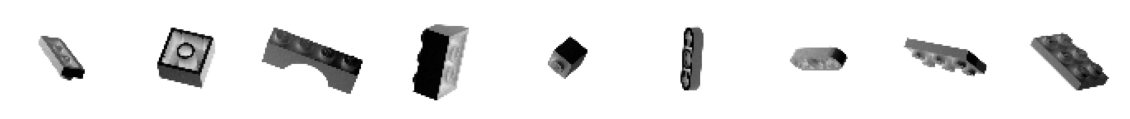

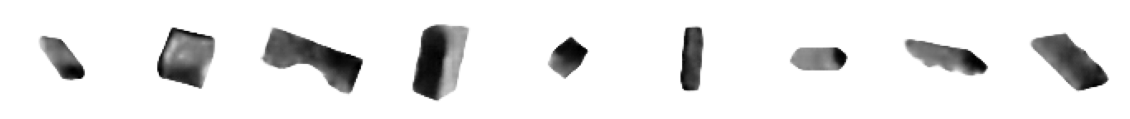

In [268]:
predictions = autoencoder.predict(test_sample)
display(test_sample)
display(predictions)

In [269]:
encoder.predict(test_sample)[0]

array([0.39047784, 0.        , 0.        , 0.        , 0.5511585 ,
       0.        , 2.427166  , 0.92456836, 0.        , 0.731755  ,
       0.        , 0.        , 0.8875183 , 0.        , 0.46600482,
       0.4673686 , 0.        , 0.640762  , 0.        , 0.        ,
       0.        , 0.        , 0.34491095, 0.        , 0.        ,
       0.        , 0.        , 0.53905135, 0.        , 0.        ,
       0.68839955, 1.5533756 , 0.        , 1.1702222 , 0.5467628 ,
       0.        , 1.5883245 , 0.13309032, 0.        , 0.6447307 ,
       0.        , 0.        , 1.6599585 , 0.        , 0.        ,
       0.28491735, 0.7205775 , 0.        , 0.        , 0.859735  ,
       0.        , 0.        , 0.7709094 , 0.        , 0.        ,
       0.6385062 , 1.6747588 , 0.        , 0.        , 0.        ,
       0.        , 1.573828  , 0.        , 0.9936201 , 0.        ,
       0.50962704, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 2.0866232 , 0.     

## 5. Denoise using the autoencoder <a name="denoise"></a>

In [199]:
noisy_train_in = noisy_train.map(lambda x: (x, x))
noisy_test_in = noisy_test.map(lambda x: (x, x))

In [17]:
history = autoencoder.fit(
    noisy_train_in,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=noisy_test_in,
)

  38/1000 [>.............................] - ETA: 9:42 - loss: 0.5887

KeyboardInterrupt: 

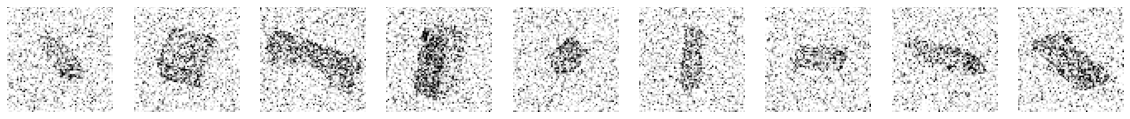

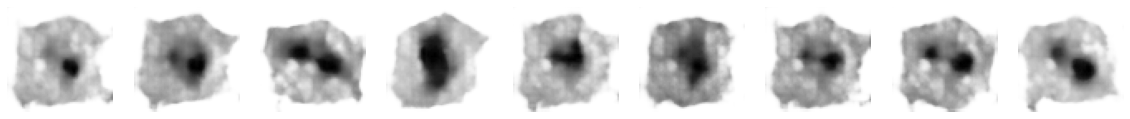

In [270]:
predictions = autoencoder.predict(noisy_test_sample)
display(noisy_test_sample)
display(predictions)